<a href="https://colab.research.google.com/github/SimplyDifficult/ML-for-Wireless/blob/main/27.%20PI_P%3D40_20_dim_user_case_BOGP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
P_max = 40 #in dBm

In [2]:
var = 20
number_of_cells = 4

In [3]:
!sudo add-apt-repository ppa:octave/stable
!sudo apt update
!sudo apt install octave

 The latest version of GNU Octave built for all supported Ubuntu releases. GNU Octave is normally distributed with Ubuntu, this PPA is for you if you have a need to use a newer version of Octave than what you can already get from your installed version of Ubuntu.

Simply follow the instructions below to add this PPA to your system and install the octave package. If it's not that easy or you encounter any errors, contact the team and let us know.

Much credit goes to the Debian Octave Group who maintain the official Debian packages that this work is derived from. Without their efforts to bring Octave packaging to such a high level of quality in Debian and Debian derivatives, this PPA would not be here.
 More info: https://launchpad.net/~octave/+archive/ubuntu/stable
Press [ENTER] to continue or Ctrl-c to cancel adding it.


Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign

In [4]:
!wget https://www.dropbox.com/s/llve9s3hfamwyni/function_uncorrelated_rayleigh_fading_channel_model.m
!wget https://www.dropbox.com/s/d1ytzzfpxsrpbcv/main_bitchanged.m -O /content/main.m
!wget https://www.dropbox.com/s/v3y2xe56qodthnm/function_SE.m
!wget https://www.dropbox.com/s/5p0j4qdqist7ibm/main_individual_transmit_case_for_Test_phase_bitchanged.m -O /content/main_individual_transmit_case_for_Test_phase.m

--2021-10-31 09:41:06--  https://www.dropbox.com/s/llve9s3hfamwyni/function_uncorrelated_rayleigh_fading_channel_model.m
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/llve9s3hfamwyni/function_uncorrelated_rayleigh_fading_channel_model.m [following]
--2021-10-31 09:41:06--  https://www.dropbox.com/s/raw/llve9s3hfamwyni/function_uncorrelated_rayleigh_fading_channel_model.m
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc80768c52009c121635bf21668d.dl.dropboxusercontent.com/cd/0/inline/BZHqMNlQexXUqIOWTmtu4JuZ6v_WaX-yPrNnKnb1pyzv8nHzX-ef1qP6ua9UvGtbKF9brUplYt2RbDamPUQYitheepDBgmWH9k8qIBHTgkX5cga0edoCnAow1DZwW8ey5ylO1m6W3K2yNpHknDwevPcP/file# [following]
--2021-10-31 09:41:06--  https://uc80768c52009c121635bf21668d.dl.dr

In [5]:
!wget https://www.dropbox.com/s/utf73kdk09gjvsu/RR.mat
!wget https://www.dropbox.com/s/52gyqiq137mo2bb/SE.mat

--2021-10-31 09:41:09--  https://www.dropbox.com/s/utf73kdk09gjvsu/RR.mat
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/utf73kdk09gjvsu/RR.mat [following]
--2021-10-31 09:41:09--  https://www.dropbox.com/s/raw/utf73kdk09gjvsu/RR.mat
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc54e210d3942b906c3d5c279b97.dl.dropboxusercontent.com/cd/0/inline/BZGiKg9eOEVh29liNCgwNa2k6biXrmgCSKdslCo-nsFuYZ2rbaYqjZmSQzJaQvl5q2m3xB91Fbsp2dIJjOCw9VO6jU2ix5JPQj_HEwHaOcxNPgfp5dc8Z4-guSsaWz-UX_wTWeEm0DLsrEmyCKM4AMI7/file# [following]
--2021-10-31 09:41:09--  https://uc54e210d3942b906c3d5c279b97.dl.dropboxusercontent.com/cd/0/inline/BZGiKg9eOEVh29liNCgwNa2k6biXrmgCSKdslCo-nsFuYZ2rbaYqjZmSQzJaQvl5q2m3xB91Fbsp2dIJjOCw9VO6jU2ix5JPQj_HEwHaOcxN

In [6]:
from numpy import arange
from numpy import vstack
from numpy import argmax
from numpy import asarray
from numpy.random import normal
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from warnings import catch_warnings
from warnings import simplefilter
from matplotlib import pyplot
from scipy.optimize import minimize
import numpy as np
from scipy.io import loadmat, savemat
import numpy as np
from google.colab import files
import cv2
from scipy.optimize import dual_annealing

In [7]:
import warnings
warnings.filterwarnings('ignore')

In [8]:
#### Objective function
import random
def objective(tr_array):
  tr_in_mW = np.power(10,tr_array/10.0)
  savemat("transmit.mat", {"transmit":(tr_in_mW)})
  !octave -W main.m
  SE = loadmat('SE.mat')
  return np.sum(SE["SE"])

In [9]:
#surrogate or approximation for the objective function
def surrogate(model, X):
	#catch any warning generated when making a prediction
	with catch_warnings():
		#ignore generated warnings
		simplefilter("ignore")
		return model.predict(X, return_std=True)

In [10]:
def PIacquisition(Xsamples, X, model):
  Xsamples = Xsamples[np.newaxis,:]
  yhat, _ = surrogate(model, X)
  best = max(yhat)
  mu, std = surrogate(model, Xsamples)
  mu = mu[:, 0]
  probs = norm.cdf((mu - best) / (std+1E-30))
  return -probs[0]

In [11]:
#optimize the acquisition function
def opt_acquisition(X, y, model):
  #Do it 5 times
  r_min, r_max = -31.0, P_max  
  bounds = []
  for ti in range(var):
    bounds = bounds + [[r_min, r_max]]
  min_result = 9999999999999.0
  min_answer = 0
  
  for i in range(1):
    result = dual_annealing(PIacquisition, bounds, args=(X,model))
    if(result.fun<min_result):
      min_result = result.fun
      min_answer = result['x']    
  return min_answer

In [12]:
import random
def objective_FPA(tr_array):
  tr_in_mW = np.power(10,tr_array/10.0)
  savemat("transmit.mat", {"transmit":(tr_in_mW)})
  !octave -W /content/main_individual_transmit_case_for_Test_phase.m
  SE = loadmat('SE.mat')
  return np.sum(SE["SE"])

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
X = np.load("/content/drive/MyDrive/trainingx_BOGP_PI_P=40.npy")
y = np.load("/content/drive/MyDrive/trainingy_BOGP_PI_P=40.npy")
y_FPA = np.load("/content/drive/MyDrive/grad_trainingyFPA_BOGP_PI_P=40.npy")

x_next is [ 39.99039651  39.99544954  39.99038728 -30.96781664  39.99291592
  35.36639442  39.97941108 -26.81731077  39.97651681  23.65174591
  -8.02076249  19.57429973 -17.11754098   0.05114255  19.43726364
  39.97892148  39.99058609 -30.9905999   17.5488459   39.98707517]
f()=52.527952, actual=48.633
0


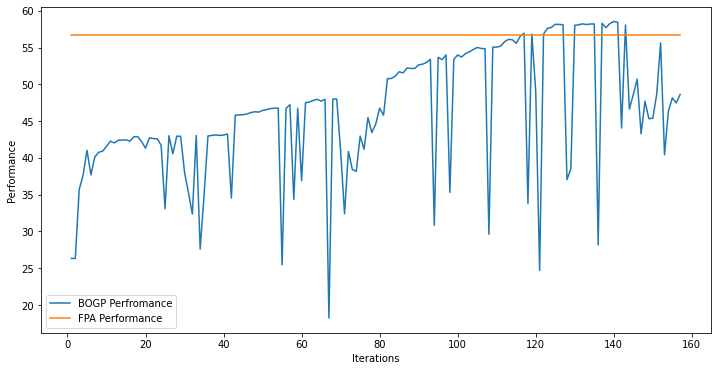

x_next is [ 39.99166465  39.97911069  39.9999997  -26.84450724  39.98987888
  39.83087361  39.98899975 -16.43554345  39.98726525  14.18362301
  -4.70968711  39.9979514  -21.7136327   39.99999935 -22.49080735
  39.99975535  39.9458753  -30.9974254   33.45536976  39.99482827]
f()=47.386618, actual=50.304
1


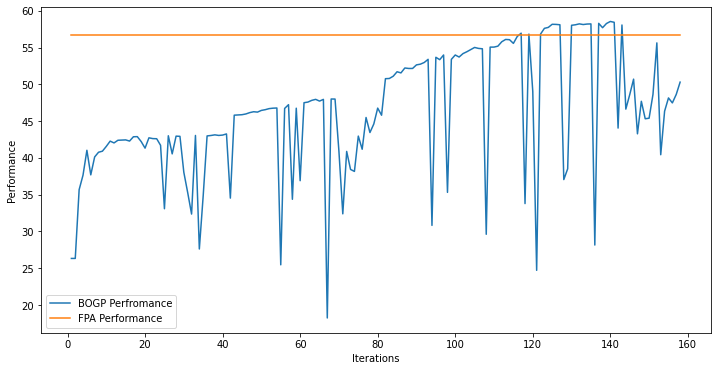

x_next is [ 39.99940023  39.99579948  39.98781675  -9.94614232  39.99721904
  39.98086182  39.99636942  -2.15112401  39.99678274  39.91085641
  19.71695776  37.04247688 -13.79351876  33.25286207  13.10307733
  39.988884    17.09460361 -30.98983048  39.95012295  39.98807962]
f()=48.219829, actual=43.042
2


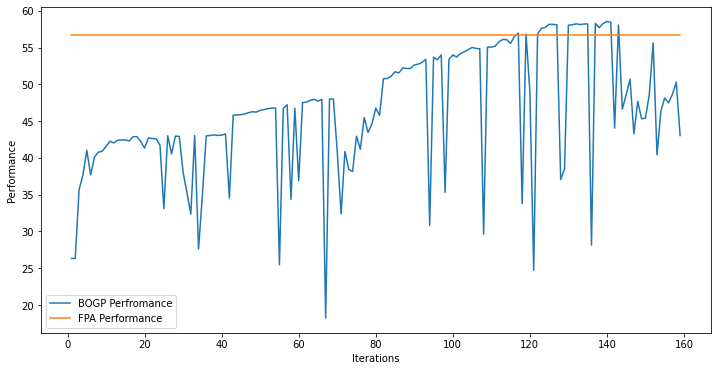

x_next is [ 39.98619817  39.9220998   39.99896521 -30.97570158  39.99976746
  31.93896209  39.99884403 -30.86312869  39.98527499  -4.333445
 -19.05347312  39.99999919 -30.95239726  39.98601412   7.86648058
  39.99928429  39.99639506   7.69226269   9.84382717  39.99896574]
f()=48.899204, actual=48.093
3


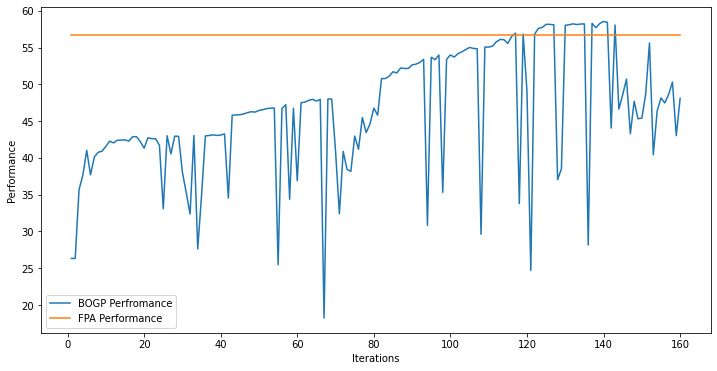

x_next is [ 39.99156811  -5.34346305  39.97986267 -30.97971891  39.99908245
  39.71811706  39.9975919  -30.59991903  39.99692753   1.78855081
 -26.40308646  39.98984266 -24.01977421  39.9874965   14.97965176
  39.99454084  39.98870426 -30.99606691  18.47053344  39.98725461]
f()=47.848207, actual=45.577
4


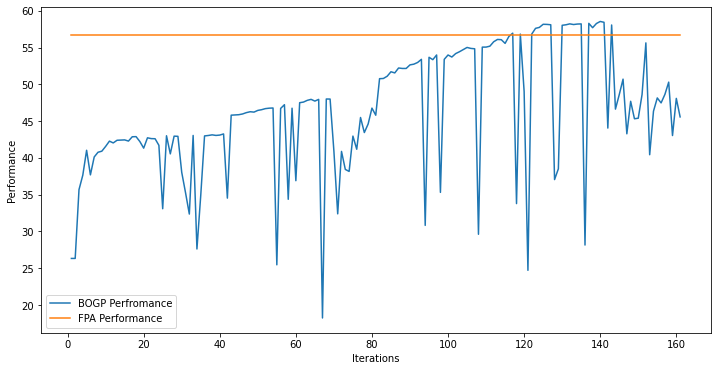

x_next is [ 39.99542064  39.9995103   -7.74247921 -30.97634309  39.98856618
  36.8017688   39.97773531 -26.48220715  39.99970057   3.88898891
 -24.57193565  39.89343328 -26.05183798  39.98704038  19.97867729
  39.99767955  39.998587   -30.99666172  20.64446702  39.99345178]
f()=47.290463, actual=48.170
5


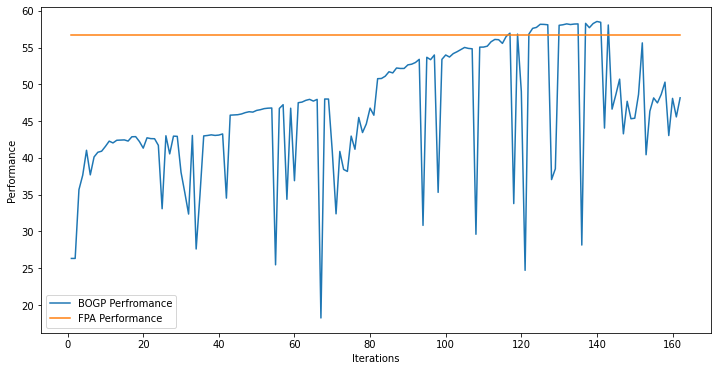

x_next is [ 39.99128094  39.99220044  39.9694956  -30.99871558  39.99128503
   9.91125965  39.99515986 -30.99752417  39.9987761   -2.50789631
  25.99085528  39.98109293 -30.91472406  28.86760644 -22.7555247
  39.98991975  39.98437793 -30.98641754  -6.60745833  39.9934944 ]
f()=47.357795, actual=43.093
6


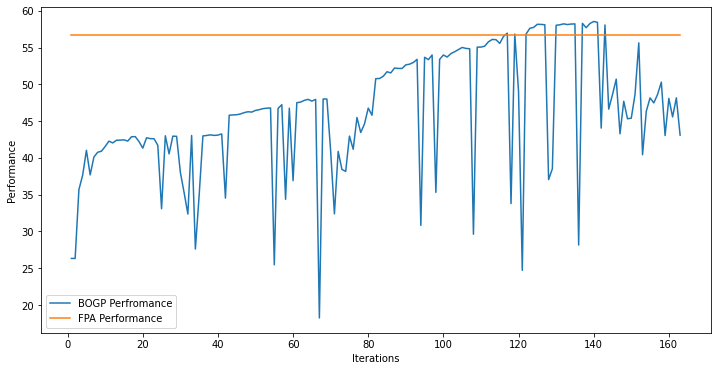

x_next is [ 37.84424935  36.42406008  34.8407608  -24.0967141   34.70508482
  26.96376777  38.00713161 -18.60374339  39.38490724  10.63956763
 -15.75122917  29.46529322 -14.62018003  35.31190677  25.69725315
  35.94504105  34.26348775 -27.01881262  15.9382694   36.78692323]
f()=69.407717, actual=51.614
7


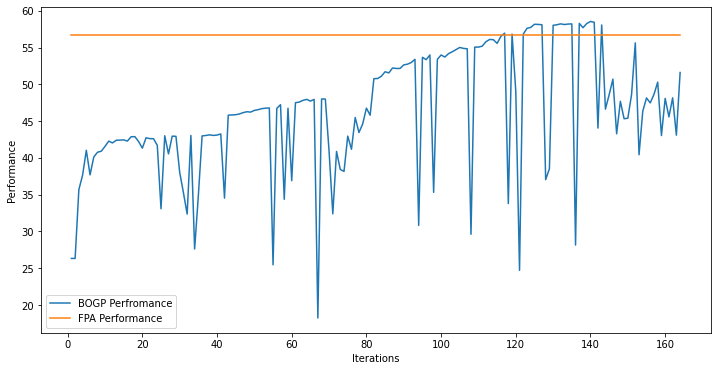

x_next is [-19.0823733  -12.77887717 -16.41910102  38.60639208  -5.30690574
 -29.25557607  31.13373957 -16.08090074  23.98831905 -19.11104754
 -25.15118702  30.53384955  34.61526386  27.50486262   8.62662553
  34.42094787 -20.41779368  32.03539836  32.62132159 -26.82072649]
f()=46.242360, actual=33.389
8


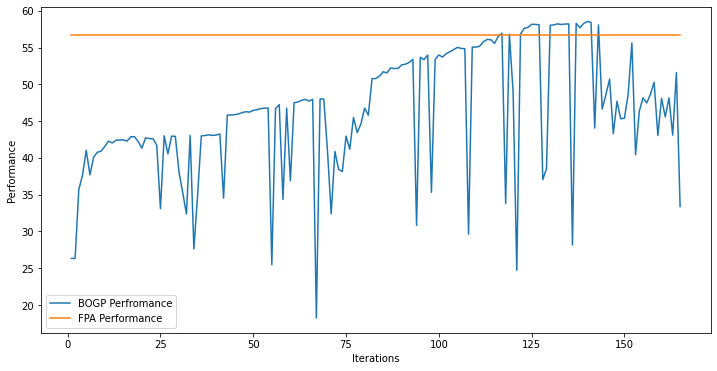

x_next is [ 39.98117824  39.99822425  39.97688173 -30.98787702  39.9952184
  33.84047224  39.99340296 -30.50786273  39.98598944   2.62461492
 -30.99571197  39.99527023  12.9358445    0.34756718 -21.39399173
  39.97516995  39.98907898 -30.97738128  39.96686541  39.99116602]
f()=47.111723, actual=45.688
9


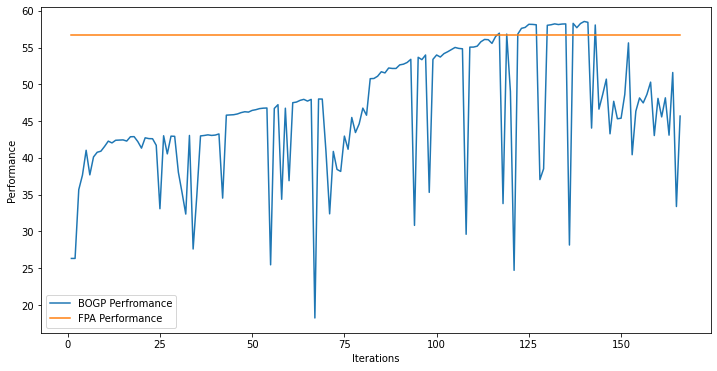

x_next is [ 39.99670791  39.99939065  39.98648468 -30.99228392  39.97348121
  38.18070144  39.98987838 -25.32834579  -7.60893144  10.53872376
 -22.34758778  30.72484515 -20.82416476  39.9040598   21.00180275
  39.97819422  39.9763358  -30.98491659  19.84615619  39.99345672]
f()=47.570220, actual=48.370
10


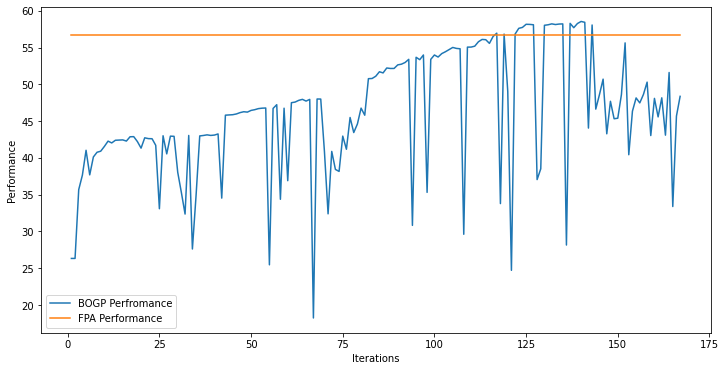

x_next is [ 39.98019385  39.99742911  38.14653229   9.55417327  39.99750114
  39.99714138  39.97069392 -10.54651453  39.97470739  -6.21169063
 -30.99399178  39.92993086 -30.89563347  35.31099926   5.20948913
  39.9747699   39.95001347 -30.97713635  15.06311758  39.98835302]
f()=48.227430, actual=45.772
11


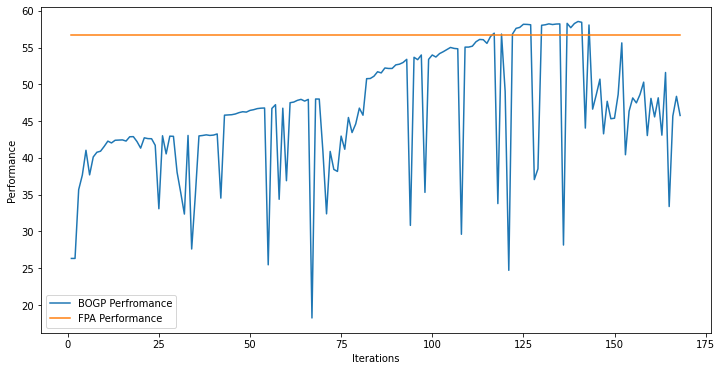

x_next is [ 39.96888664  39.99467043  39.99658028 -30.99892194  39.99644562
  39.99420283  39.98787254 -30.7913055   39.9777043   -7.25755694
   6.9176531   39.99341589 -30.82513216  22.89963741   6.28579846
  39.99244573  39.99999772 -30.9728318   39.99322111  -0.537502  ]
f()=46.253057, actual=40.594
12


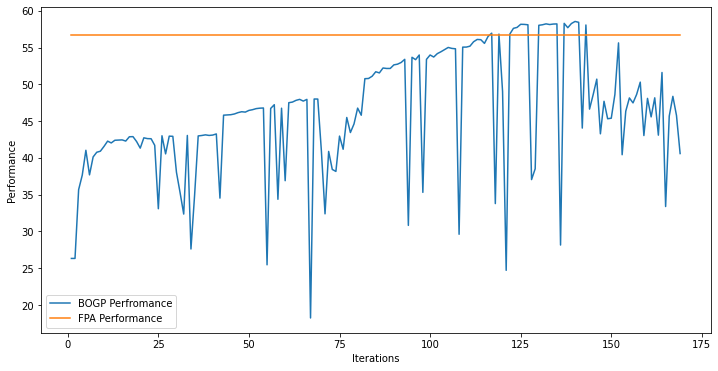

x_next is [ 27.84323105  39.9996774   13.44841212  15.77739502  -0.62978145
  27.1985052   33.40585723 -21.81613496  39.95085615  19.17826914
 -30.48871562 -30.63127908  32.9376018   11.46458644  39.99532759
  18.9052068   28.80100278 -14.49655414  21.34953829  22.85639363]
f()=58.608047, actual=58.524
13


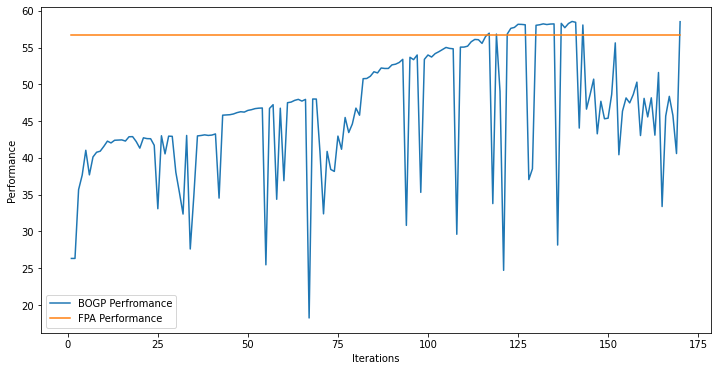

x_next is [ 39.98753806  39.99754185  37.41292515 -30.99799558  39.99680701
  39.98039345  39.98053676 -30.99773018  39.98238199  39.95811565
 -30.92135251  -0.32019206 -14.01717204  39.99581127  -8.49348691
  39.99239196  39.99240082 -30.99341323  22.26034733  39.99624583]
f()=49.041603, actual=47.107
14


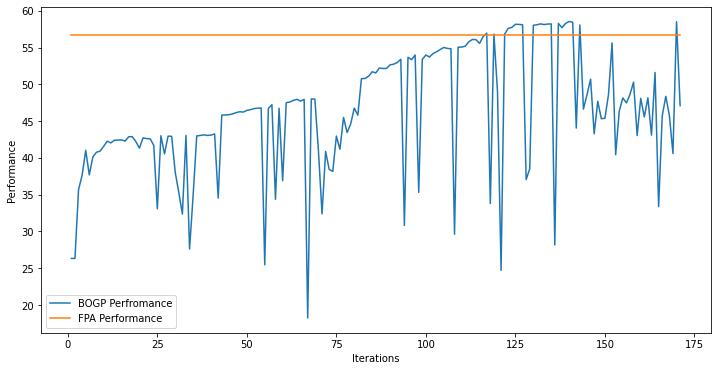

x_next is [ 13.74115473   3.26518752  -3.72146045  36.66227708 -11.27827548
  28.33213066  38.10768224  30.49965269  33.61324463   4.49118022
 -26.16741094  26.36319998  11.77998878  15.53259738  -2.46610487
 -17.28701328  11.07833105   2.17760356 -11.78924181 -16.42102808]
f()=46.217582, actual=33.590
15


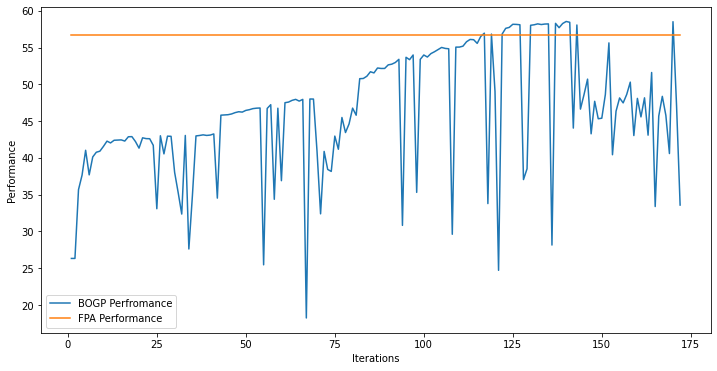

x_next is [ 39.61268201  39.5732817   39.94568264 -30.9530729   39.82487943
  39.56248792  39.28361518 -30.46690051 -30.48873906  39.87815082
  39.44712521  39.88874883 -30.90998917 -30.62006638 -30.67577024
  39.96207875  39.95320034  37.31683426  39.68076812  39.91149918]
f()=39.490943, actual=47.061
16


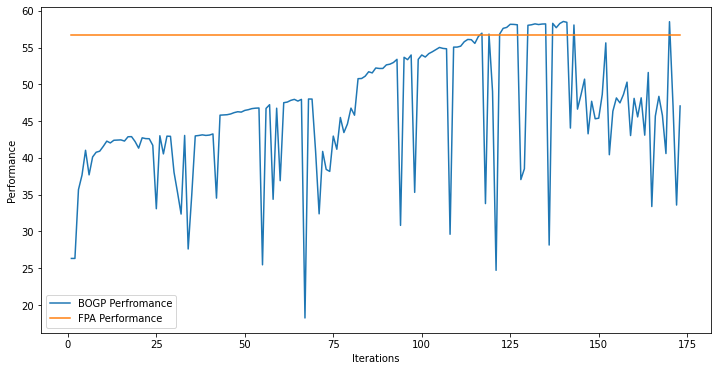

x_next is [ 39.99590368  39.96672     39.99666467 -30.98523516  39.99149667
  39.995175    39.99776891 -30.90957091   3.81238727  39.95885437
  21.49946681  30.78347752   8.63321904   3.72858294 -30.9176857
  39.9923231   39.99624272   4.60441862  39.98612105  39.9972241 ]
f()=48.227764, actual=44.015
17


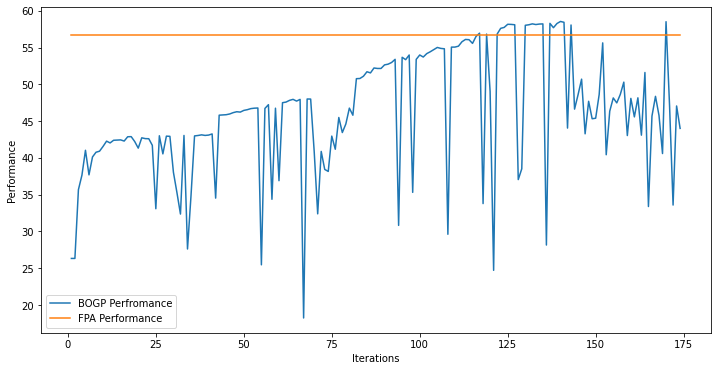

x_next is [ 39.9941799   39.99740864  39.95948884 -30.978272    39.96883658
  17.73588413  39.97613082  10.40136579   4.9231024   27.95812325
  -3.91001629  39.98671914 -30.99610499 -30.99605302 -28.11653641
  39.97941702  39.99313242  -1.43118049  39.83489666  39.99247104]
f()=45.616715, actual=45.586
18


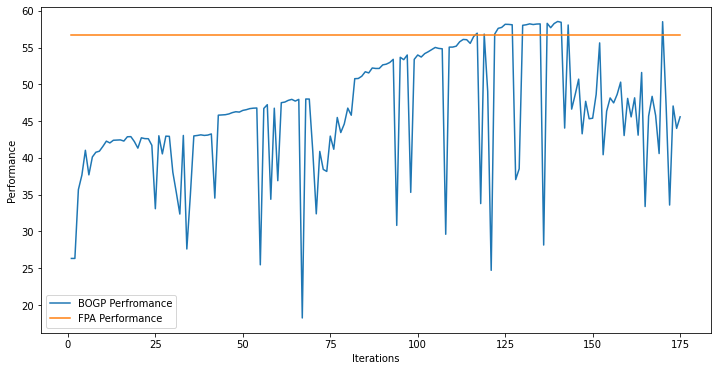

x_next is [ 39.99540551  39.98677764  34.61633784 -20.11493652  25.78138968
  27.52543035  39.68059606 -24.95998018   6.8877506   17.74777756
  12.35531807  30.77760913 -30.94775417  -5.73342684  -3.89077325
  25.06057648  32.11716658   3.04613045  27.98654948  39.99883992]
f()=50.069057, actual=45.919
19


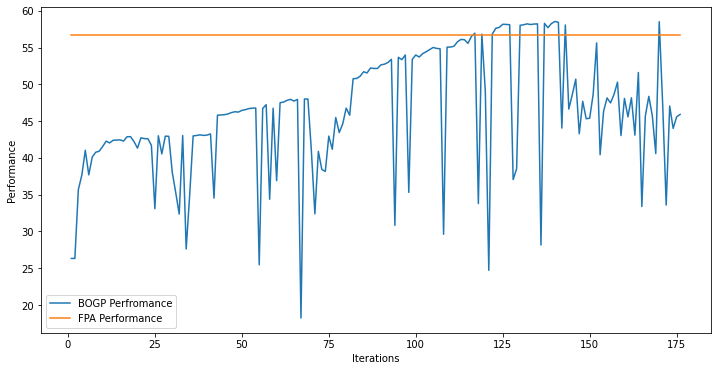

x_next is [ 28.70997379  32.91134492  13.05086222  18.90125881   5.01803565
  35.54543972  31.34430731 -17.47823157  39.49612054  23.08121137
 -17.66389008 -16.45316271  17.85119513  16.04611318  31.38369634
  10.95600813  26.48893935 -17.55305014   0.27265824  31.15056238]
f()=50.814921, actual=48.079
20


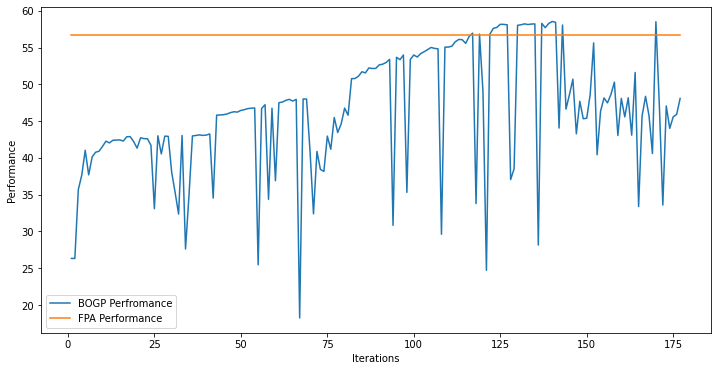

x_next is [ 39.97862898  39.98903007  39.99404192 -30.99385268  39.99681689
  39.98199896  39.99271176 -30.76593579 -30.9548955   39.96138881
  39.94359918  -5.43761105 -30.98729537 -30.99345006 -18.50708544
  39.99588857  39.99538448 -30.99103443  39.95856499  39.99953407]
f()=42.844122, actual=43.983
21


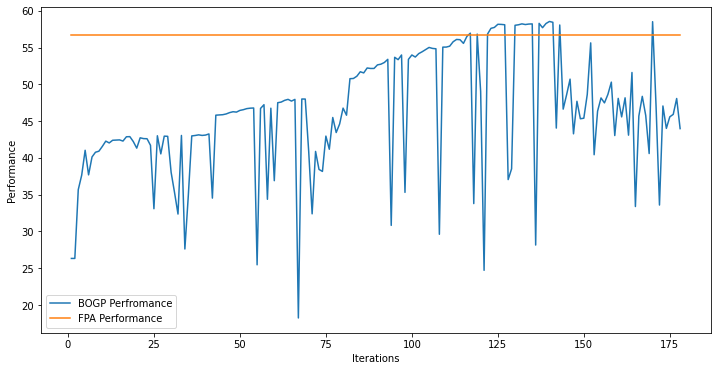

x_next is [ 4.04231175e+00  3.93660581e+01 -2.11935473e+01  3.38513574e+01
  1.17535286e+01  3.72381979e+00  8.04624525e-01 -2.48265556e+01
 -2.22916764e+01  3.23680450e+01  5.76376834e+00  3.88590767e+01
  2.77163584e+01 -1.30590568e+01 -5.10977727e+00  1.85599774e-02
  7.04303845e+00  1.63343755e+01  2.83402951e+01  3.04568230e+01]
f()=46.131877, actual=34.019
22


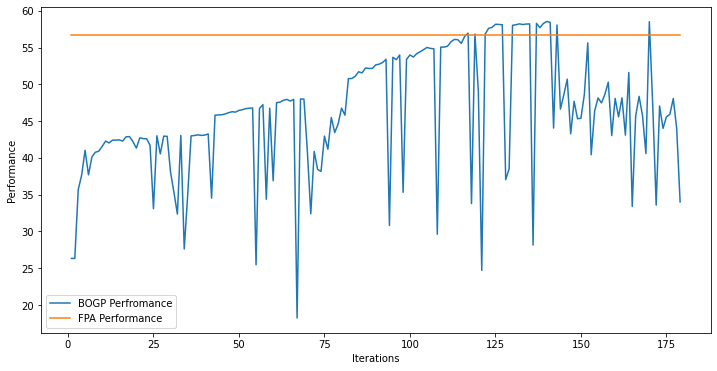

x_next is [ 39.9664508   39.99069642  39.97835106 -30.97239724  39.97426291
  -0.39463657  39.9820246  -30.98680387 -22.56954266  39.98029473
  39.73925975  39.98010314 -23.80261878 -30.99182127  39.98772495
  39.99651681  39.99905589   7.08056532  13.57879752  39.99535325]
f()=42.191776, actual=43.534
23


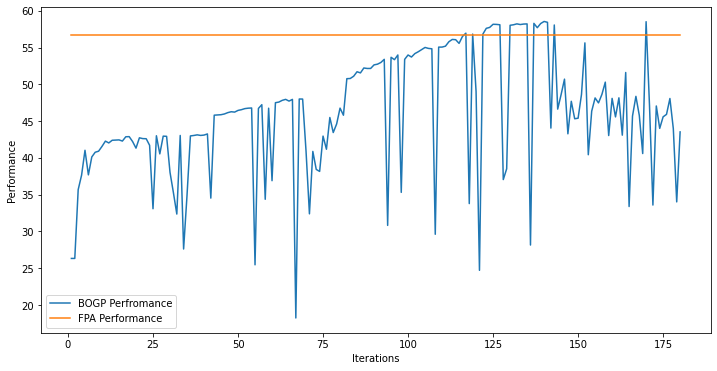

x_next is [-22.43000075  39.98239742  39.99271483 -30.99770186  39.9934219
  39.9788323   39.99758058 -30.96738751   2.30259918  39.97676639
  21.22476551  39.97664897 -30.97881315 -30.9988884  -20.32572909
  39.99919925  39.99596638  -3.75488982  39.91990387  39.98675477]
f()=42.735009, actual=40.863
24


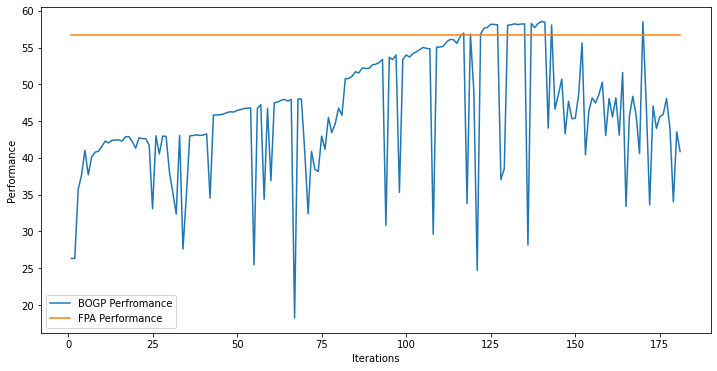

x_next is [ 23.37096036  25.78843277  28.9245017  -10.61115818  32.68569267
  19.03096223  17.82433573 -22.33447635 -18.58651252  23.33459474
   9.03305125  13.39085819 -27.8777726   -3.93516942  -7.06463058
  16.76494912  37.12706669   6.60001849  32.57064448  28.33697188]
f()=40.457759, actual=38.776
25


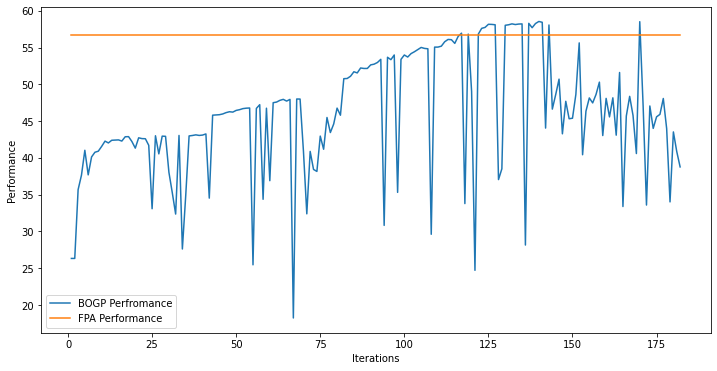

x_next is [ 13.14354925  31.26312528 -15.83452129  19.57857128  18.43600198
   3.75625858 -21.83841828   3.26867622  24.20019196  30.79710825
 -25.80855701   7.05362504  36.02503479  20.55334476  -2.56114324
  -5.19912305  27.53520846  39.4115564   29.51426884   0.26499642]
f()=45.981684, actual=35.530
26


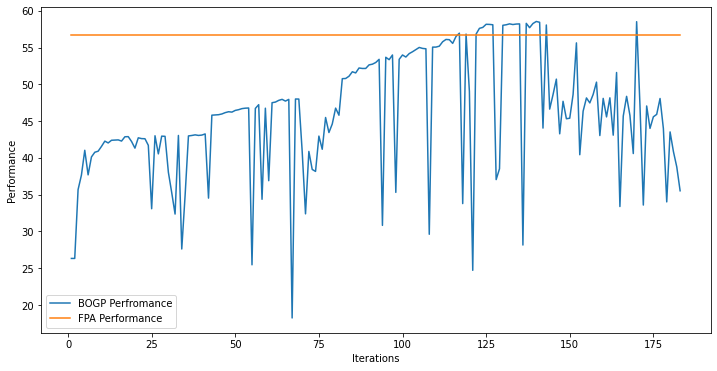

x_next is [ 39.96184353  39.97182683   9.58315429  -3.5921324   39.9772659
   5.43324203  39.97843076 -18.29582457  39.85072463  14.58144921
 -30.96128305  39.96667891  -8.45206377  39.99721935  39.97798453
  39.9544561   39.96469166   8.35035384   4.00287005  39.96944803]
f()=47.075195, actual=46.796
27


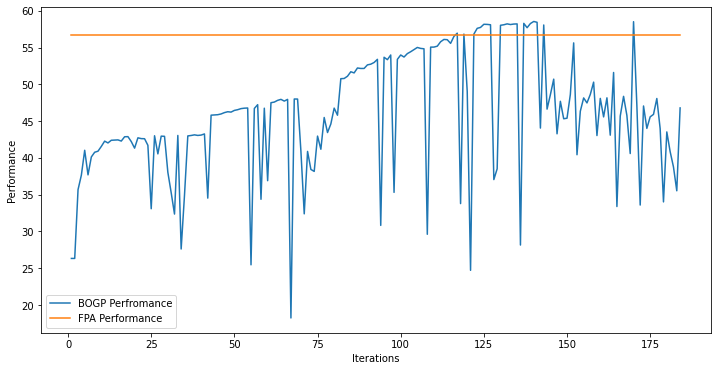

x_next is [ 39.97914228  39.99663645  39.92013648 -30.98164924  39.99917703
  12.37773727  39.99364381 -18.2266592   17.40748144   1.75420191
 -30.98359642  39.93085615  -6.6150366    6.74423878  39.97558109
  39.99826223  39.99615329 -30.74486516 -11.84909793  39.99970949]
f()=48.119902, actual=43.279
28


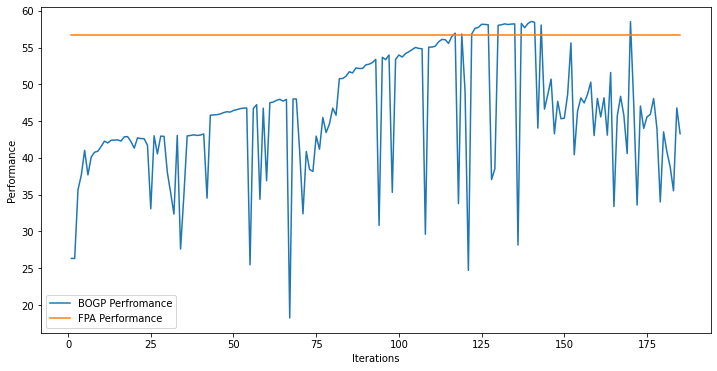

x_next is [ 39.99824024  39.98963382  39.96231283 -30.99441933  39.99699915
 -11.23786107  39.98197614 -30.98527958  39.95141528  39.97446545
  39.98434056  39.94820437 -30.99053141 -30.97422527 -27.14123504
  39.97984512  39.95829545  39.97418429  39.9973091   39.99959285]
f()=42.121054, actual=44.843
29


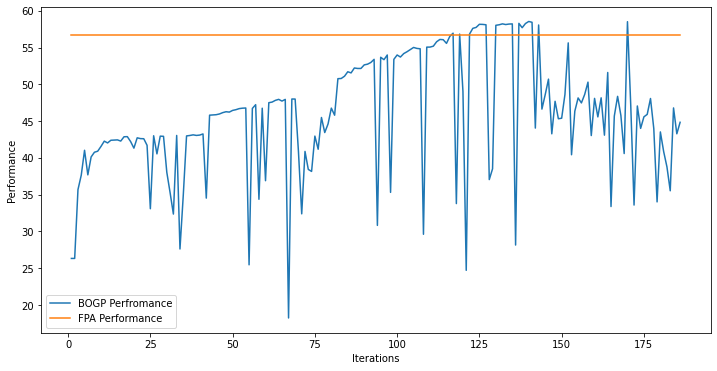

x_next is [ 39.99897513  39.98789165  39.99355418 -30.99310148  39.99942271
  39.99623978 -14.42905202 -25.40720648  27.92908369  39.99548673
  39.98597175  39.96350327 -30.9961391  -30.98839526   2.22924238
  39.99523882  39.99815824  25.26093236  39.97573573  39.99346922]
f()=42.621696, actual=43.464
30


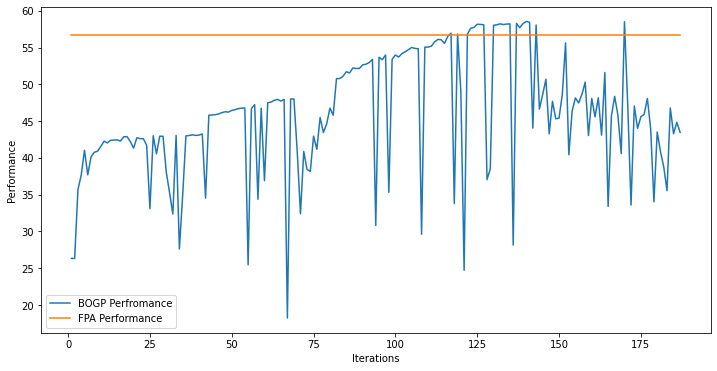

x_next is [ 39.99834628  39.99197846  39.97532586 -30.99964186  39.98189799
  31.7747004   39.99896084 -30.99297398   4.78501274  39.67387837
  39.80270858  39.95262871 -30.99984029 -30.98056183 -30.99246057
  39.99221102 -28.40629579  17.14229286  39.9984084   39.99467754]
f()=41.990102, actual=40.707
31


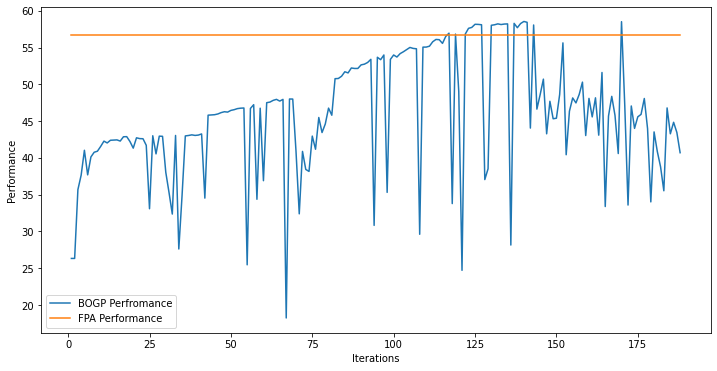

x_next is [ 39.98571748  39.98932308 -22.65739038 -30.99842671  39.99054303
  39.99334537  39.99311843 -22.10691588  20.95496952  39.98435807
  39.99136023  39.96372576 -30.99408473 -30.99961263 -19.85031961
  39.99703919  39.98979974  15.44268322  39.97031529  39.97843199]
f()=42.813881, actual=44.791
32


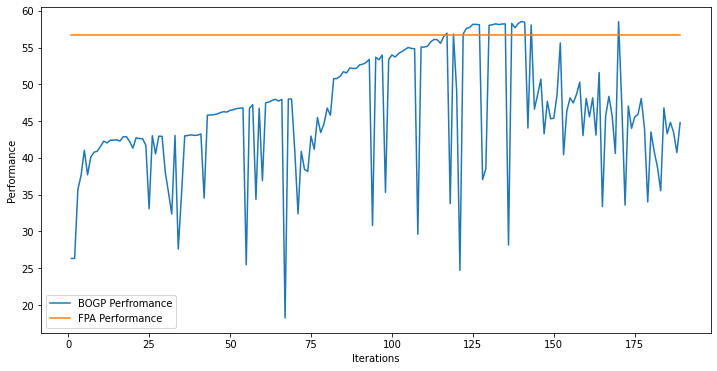

x_next is [ 39.99829838  39.97736761  39.91956539  33.34381596  39.99261783
  39.89815412  39.99533807 -30.99159729  16.43642493  39.95352028
  39.95188316  39.99018019 -30.99326356 -30.96890929 -30.99959681
  39.98597147  39.98490215  22.20759007  39.9733719   39.97276797]
f()=41.632267, actual=48.869
33


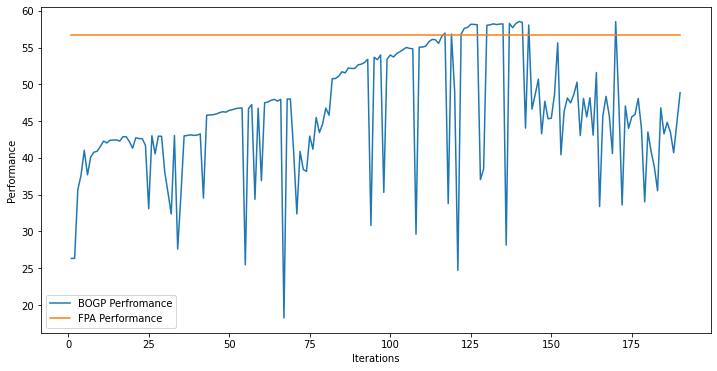

x_next is [-30.44016547 -27.47382311 -21.71620607 -28.41444128  -9.57982598
  29.0731389   21.27970868 -19.75911013   9.83093253 -22.29768682
 -21.88003715  13.76122715 -28.78079576  23.79916282  12.53801427
  12.44583054  -4.73464501   1.8428141  -10.18140267   7.29424697]
f()=31.558779, actual=26.219
34


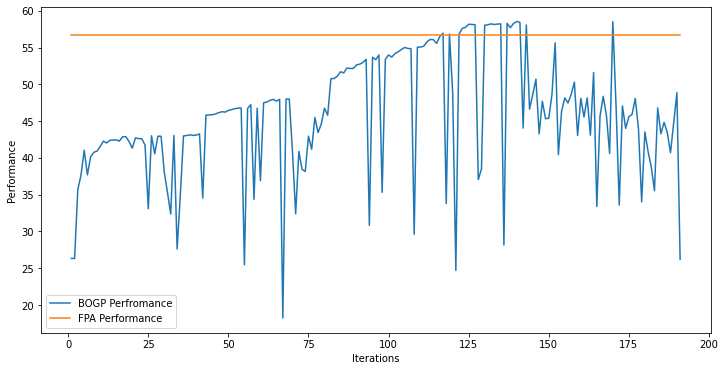

x_next is [ 39.98507946  39.97768782  39.96955282  -1.02204623  39.97912728
  39.95704168  39.99984985 -10.21024453  23.57873555 -13.85488741
  39.99308211  39.9902524  -30.98586659 -30.99779345 -30.96413977
  39.98888958  39.99839237  39.95285441  39.93316586  39.99446464]
f()=44.749601, actual=47.660
35


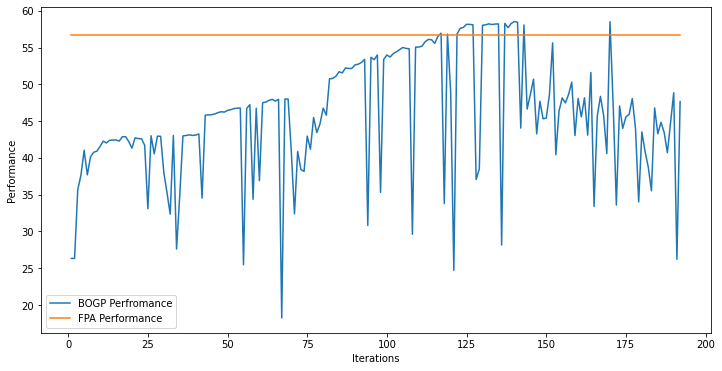

x_next is [ 39.99218374  39.98769735  39.94821586   1.53641456  39.99617609
  39.96971326  39.99702193 -30.99867768  25.18202668  31.38242948
  39.99199507  -7.87767132 -30.98789855 -30.99126772  12.93090531
  39.99617513  39.99632301  39.96026793  39.9792385   39.9957921 ]
f()=45.174254, actual=49.435
36


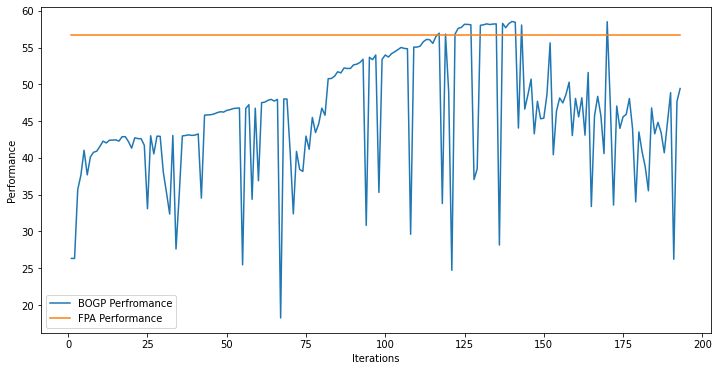

x_next is [ -3.99838176  31.17651068  -3.17875515  15.57187375  29.45911658
  25.9607877   32.29983996 -30.03865487  39.32236514  38.59676082
 -29.18551945  39.34737641  -5.21703196   7.94682644  27.743263
  38.45373859  23.3060104  -26.558502     2.32077676  -3.23429394]
f()=45.804525, actual=34.450
37


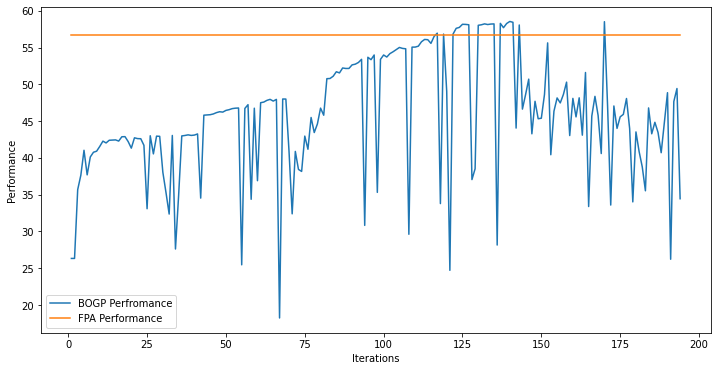

x_next is [ 39.99323012  39.98778845  32.60654898  15.02768381  39.99307706
  39.98840666  39.99168347 -30.98526631  23.67266596  19.18454004
  39.98751122  39.97062814   5.1895717  -30.99225077  26.15083166
  39.97434135  39.99598738  39.98299531  39.97280141  39.9970973 ]
f()=46.294931, actual=49.924
38


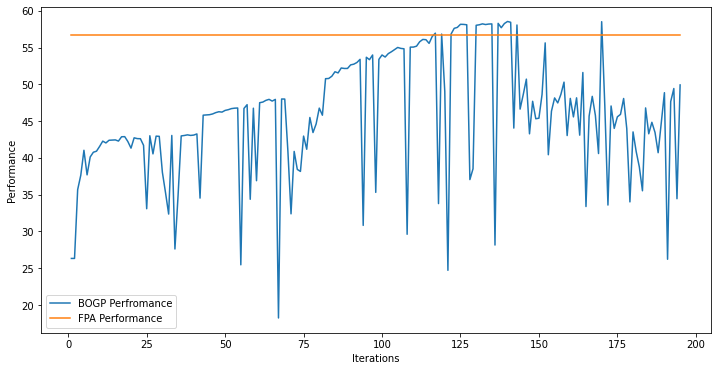

x_next is [ 39.97497989  39.99688153  19.85272745  37.16381896  39.99708852
   5.57985297  39.99739687 -30.98127162   5.34813806   0.53215723
  39.98943884  27.83513824 -30.99819451 -30.98002428  16.38631274
  39.97208098  39.97358013  39.95495565  39.99454922  39.9786947 ]
f()=46.212978, actual=46.086
39


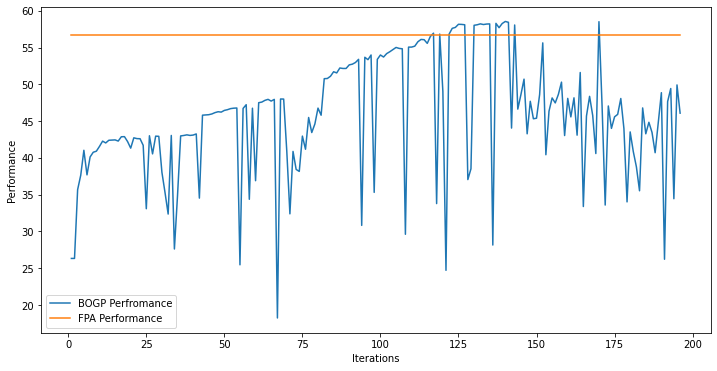

x_next is [ -3.70668601   4.38783706  16.01412541  -9.51069513  29.41390778
   7.514481    18.60345945   4.69650694  -0.91802331  17.51954458
 -18.0804966  -27.63245431  25.87302267  24.45268481  19.70240675
  -4.97525935  28.48676956  29.98444463  31.29205177  -9.19485002]
f()=34.794677, actual=35.736
40


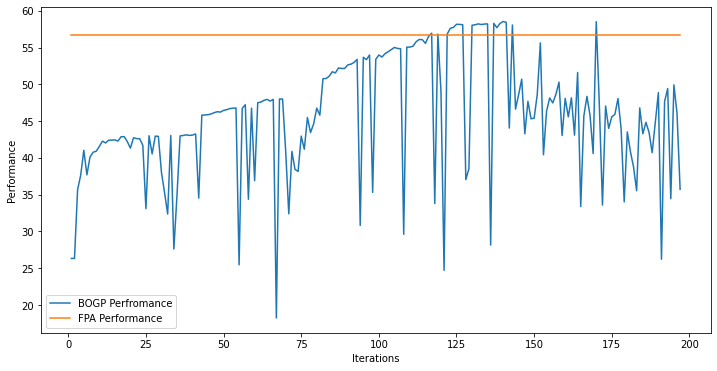

x_next is [ -7.54494235   2.47802523   4.94907311   6.11279415 -26.06230132
  34.8258916   38.07693928 -10.85778722 -26.3173963    8.51476187
 -29.11398076  14.0472478   -5.787552   -26.08434497  17.98954774
  12.14650471  22.28786621   5.30068256  22.28574147  25.50541788]
f()=45.723903, actual=34.754
41


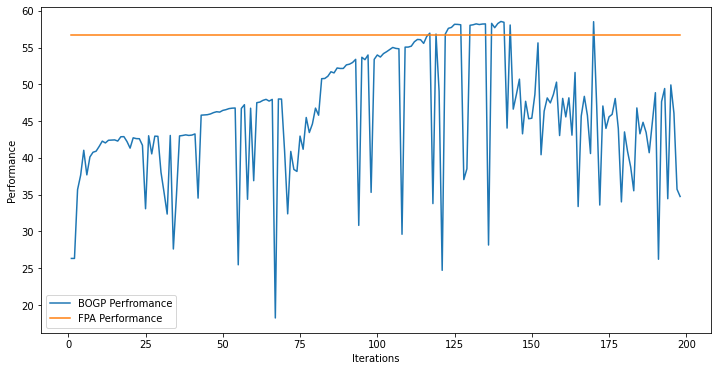

x_next is [ 39.974535    39.99747605  39.94370066  -7.00323364  39.9894247
  39.98321331  39.99995241 -30.97843565  39.96588869  21.34851317
  39.98282324  39.9560603  -30.98089494  15.4728059   39.98486517
  39.99178635  39.98898776  39.99343277  39.99999982  39.99703052]
f()=46.421496, actual=51.182
42


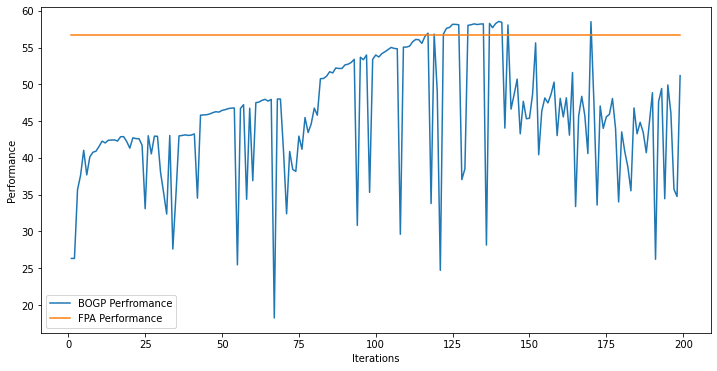

x_next is [ 39.99859192  39.99413168  11.48094957  24.17664663  39.96935876
  39.99820639  39.97418844 -30.99257153  39.9874529    5.60338963
  39.95838977  22.27622769 -12.58790783  29.15017791   9.74105648
  39.99162296  39.99465273  39.98129213  39.98507251  39.9906932 ]
f()=47.056064, actual=49.134
43


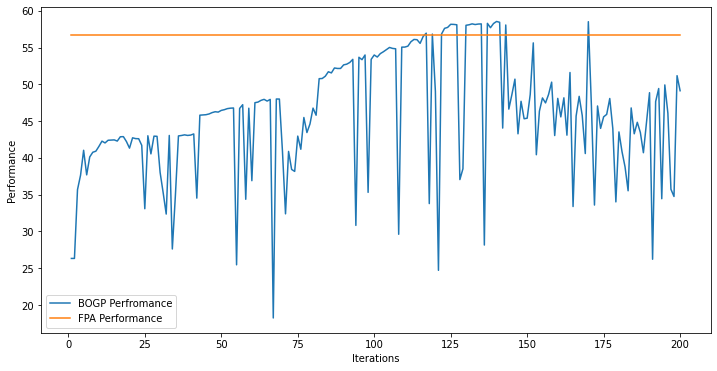

x_next is [ 39.98741599  39.9922688   38.48776038   8.38200982  39.99621173
  39.99860109  39.99924755 -30.99537749  39.9452368   26.16519237
  39.98565692  39.97319388 -30.99025954 -26.81641103  12.01249849
  -2.54828673  39.9855055   39.99515601  39.99406751  39.99377814]
f()=47.467822, actual=48.178
44


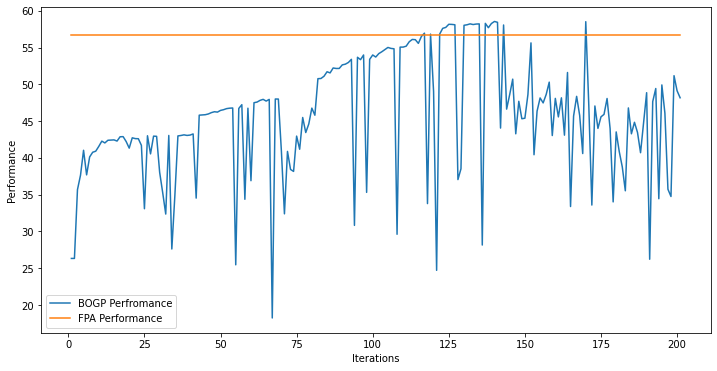

In [ ]:
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel


kernels =  ConstantKernel(constant_value=200, constant_value_bounds = (1e-20, 1e20)) * Matern(length_scale=1, length_scale_bounds=(1e-20,1e20), nu=1.5) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-20, 1e20)) 
model = GaussianProcessRegressor(kernel = kernels, n_restarts_optimizer=30)

model.fit(X, y)

for i in range(45):
  x_next = opt_acquisition(X, y, model)

  np.save("/content/drive/MyDrive/trainingx_BOGP_PI_P=40.npy",X)
  np.save("/content/drive/MyDrive/trainingy_BOGP_PI_P=40.npy",y)
  np.save("/content/drive/MyDrive/grad_trainingyFPA_BOGP_PI_P=40.npy",y_FPA)
  
  tr = 0
  for l in range(1):
    tr = tr + objective_FPA(x_next.reshape((int)(var/number_of_cells), number_of_cells))
  tr = tr/1.0  
  actual = tr

  tr_FPA = objective_FPA(P_max * np.ones([1,var], dtype = "float").reshape((int)(var/number_of_cells), number_of_cells))
  
  est, _ = surrogate(model, [x_next])
  print("x_next is", x_next)
  print('f()=%3f, actual=%.3f' % (est, actual))
  
  X = vstack((X, [x_next]))
  y = vstack((y, [[actual]]))
  y_FPA = vstack((y_FPA, [[tr_FPA]]))
  
  model.fit(X, y)

  print(i)
  pyplot.figure(figsize = (12, 6))

  pyplot.xlabel("Iterations")
  pyplot.ylabel("Performance")
  pyplot.plot(np.arange(1,X.shape[0]+1),y[:])
  pyplot.plot(np.arange(1,X.shape[0]+1), y_FPA[:])
  pyplot.legend(["BOGP Perfromance","FPA Performance"])
  pyplot.show()


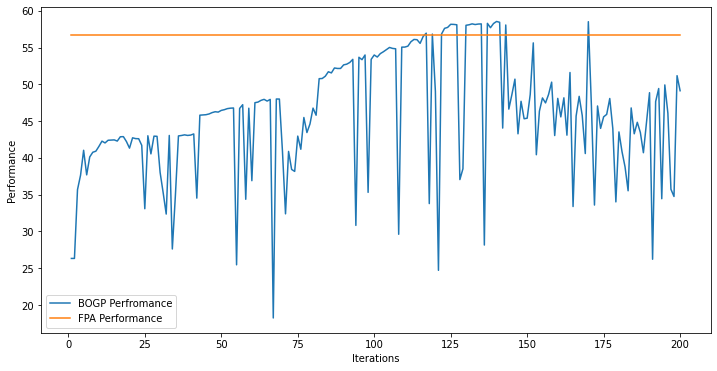

P_max = 40.000, Optimal_SE = 58.554
P_max = 40.000, Optimal_SE_FPA = 56.682


In [17]:
pyplot.figure(figsize = (12, 6))   
pyplot.xlabel("Iterations")
pyplot.ylabel("Performance")
pyplot.plot(np.arange(1,X.shape[0]+1),y[:])
pyplot.plot(np.arange(1,X.shape[0]+1), y_FPA[:])
pyplot.legend(["BOGP Perfromance","FPA Performance"])
pyplot.show() 
ix = 0
ix = argmax(y)
print('P_max = %.3f, Optimal_SE = %.3f' % (P_max, y[ix]))

ix_FPA=0
ix_FPA=argmax(y_FPA)
print('P_max = %.3f, Optimal_SE_FPA = %.3f' % (P_max, y_FPA[ix_FPA]))

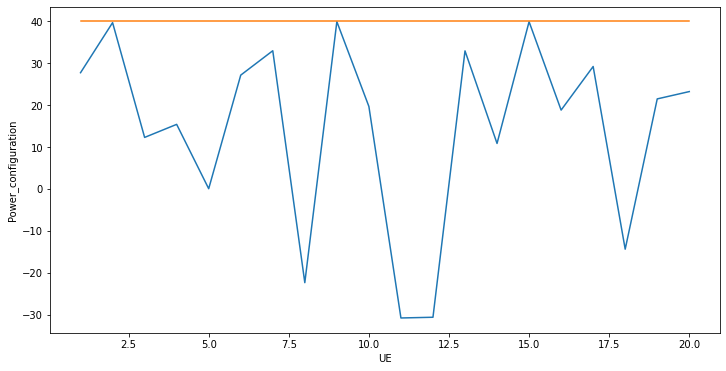

Power_configuration_BOGP is [ 27.75790053  39.71663847  12.30446383  15.42121531   0.054335
  27.18171746  33.00656681 -22.39022337  39.95839133  19.6975205
 -30.82669881 -30.65353853  32.97282596  10.86226262  39.9392832
  18.82946537  29.24287827 -14.39396495  21.50303238  23.25192749]


In [18]:
X_FPA = P_max * np.ones([1,var], dtype = "float").reshape((int)(20), 1)
pyplot.figure(figsize = (12, 6)) 
pyplot.xlabel("UE")
pyplot.ylabel("Power_configuration")
pyplot.plot(np.arange(1,21),X[ix][:])
pyplot.plot(np.arange(1,21),X_FPA[:])
pyplot.show()
print("Power_configuration_BOGP is", X[ix])

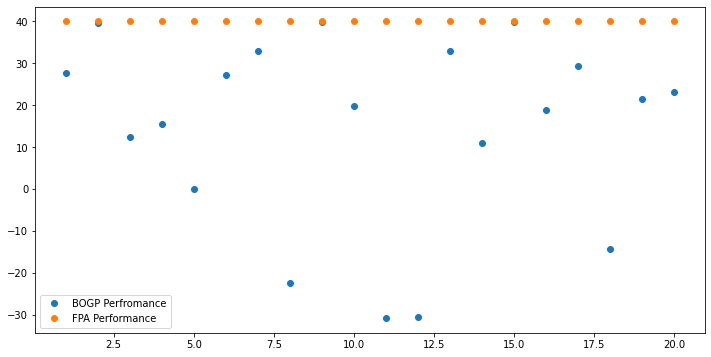

Power_configuration_BOGP is [ 27.75790053  39.71663847  12.30446383  15.42121531   0.054335
  27.18171746  33.00656681 -22.39022337  39.95839133  19.6975205
 -30.82669881 -30.65353853  32.97282596  10.86226262  39.9392832
  18.82946537  29.24287827 -14.39396495  21.50303238  23.25192749]


In [19]:
import matplotlib.pyplot as plt
X_FPA=np.linspace(P_max,P_max,20)
plt.figure(figsize = (12, 6)) 
plt.plot(np.arange(1,21),X[ix][:], 'o')
plt.plot(np.arange(1,21),X_FPA[:], 'o')
plt.legend(["BOGP Perfromance","FPA Performance"])
plt.show()
print("Power_configuration_BOGP is", X[ix])